# Practical 2: Trend Analysis of Snow-Covered Area (SCA) using MODIS Snow Data

Content prepared by Swun Wunna Htet

Step 1: install GEE python API in the colab environment

In [ ]:
# ! pip install geemap

! pip install pycrs
! pip install geetools

Step 2: import python libraries to utilize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import ee
import geemap
import geetools

Step 3: Authenticate and initialize earthe engine. If you have a specific GEE projects specify that project

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'ee-swunait')

Connecting with your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# date filter of image collection
start = ee.Date('2020-01-01')
end = ee.Date('2020-12-31')

We will upload our shapefile of area of interest into your GEE project assets.

In case you have error message (No module names pycrs), run this code in an new cell;
! pip install pycrs

In [ ]:
aoi = geemap.shp_to_ee(r'/content/drive/MyDrive/cryosphere_monitoring/filtered_tibet_watershed.shp')

In [ ]:
# Let's see our metadata of aoi. AOI is now termed as Feature Collection.
display(aoi)

We will filter our Landsat 8 image collection with date and only within area of interest for a few selected band.

In [ ]:
band = ['NDSI_Snow_Cover', 'NDSI_Snow_Cover_Basic_QA']
# importing the L8 imagecollection specific within the date range
terra = ee.ImageCollection("MODIS/061/MOD10A1").filterDate(start, end).filterBounds(aoi).select(band)

Let's check out the metadata of L8 collection

In [ ]:
# Let's see what kind of metadata L8 single ee.image has to offer
display(terra.limit(10))
display(terra.size())

MODIS datasets have sinusoidal projection which requies reprojection.

In [ ]:
# create function for reprojection each ee.Image of MODIS
# this function clip, reproject and quality mask the images of MODIS
def clip_reproj_msk(img):

  image = img.clip(aoi)

  # quality mask
  qa = image.select(band[1])

  badbit = 1 << 3

  msk = qa.bitwiseAnd(badbit).eq(0)
  msk_image = image.select(band[0]).updateMask(msk)

  # reprojection
  reproj_msk_img = msk_image.reproject(crs = 'EPSG:4326', scale = 500)

  # clipping
  clip_reproj_msk_img = (reproj_msk_img.clip(aoi)).copyProperties(img, ['system:time_start'])

  return clip_reproj_msk_img

In [ ]:
terra = terra.map(clip_reproj_msk)

display(terra.limit(10))

Visualize the SCA maps of MODIS in the interactive basemap


In [ ]:
# checking the first DOY and last DOY
meanSCA = terra.mean()

In [ ]:
# we will create a map layout
basemap = geemap.Map()

In [ ]:
# adding area of interest and annual mean result in the map

basemap.addLayer(aoi, {'color': 'blue', 'opacity': 0.5}, 'Area of Interest')
basemap.addLayer(meanSCA, {'min':0, 'max':100, 'palette':['red', 'blue']}, 'Annual mean SCA')

In [ ]:
basemap

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Establish the time series of MODIS time series

In [ ]:
def extractSCAtime(img):
  sca_img = img.select(band[0])

  mean = sca_img.reduceRegion(reducer = ee.Reducer.mean(),
                           geometry = aoi,
                           scale = 500)
  val = mean.get(band[0])

  return img.set('Date', img.date().format()).set(band[0], val)

In [ ]:
sca_time_series = terra.map(extractSCAtime)

nested_scalist = sca_time_series.reduceColumns(ee.Reducer.toList(2), ['Date', band[0]]).values().get(0)

We will use from two list in imagecollection into pandas dataframe

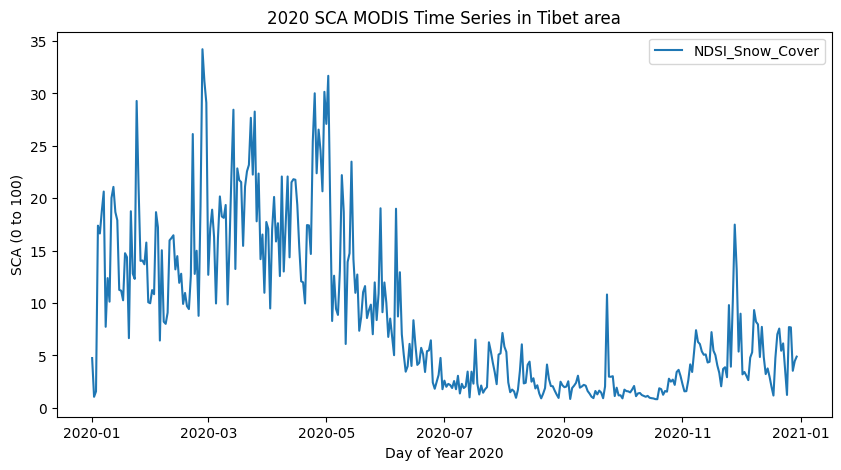

In [ ]:
df =pd.DataFrame(nested_scalist.getInfo(), columns=['Date', band[0]])
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Plotting the time series of SCA for 2020
fig, ax = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df, ax = ax)

ax.set_ylabel('SCA (0 to 100)', fontsize = 10)
ax.set_xlabel('Day of Year 2020', fontsize = 10)
ax.set_title('2020 SCA MODIS Time Series in Tibet area', fontsize = 12)

plt.show()

Saving the SCA Time Series as Excel Sheets

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/cryosphere_monitoring/MODIS_SCA_timeseries_2020.xlsx', engine = 'openpyxl')

df.to_excel(writer, sheet_name = 'SCA')
writer.close()

---
Trend Analysis using Mann Kendall Test and Sen's Slope

---
Mann Kendall test is to statistically investigate the significant increasing/decreasing trend at a particular location.

Mathematically, it is the sum of signs of all pairs of measurements. We will create functions of the calculation of sign results of each measurement pair.

In [ ]:
# in GEE we have the function of Mann-Kendall from ee.Reducer.kendallsCorrelation()
kendall = terra.reduce(ee.Reducer.kendallsCorrelation())

display(kendall)

# Notice in the display that the trend is termed as Tau and its p-value

In [ ]:
sca_trend = kendall.select("NDSI_Snow_Cover_tau")
sca_pval = kendall.select("NDSI_Snow_Cover_p-value")

trend = sca_trend.multiply(sca_pval.lte(ee.Image(0.05)))

Visualizing the man kendall result

In [ ]:
basemap.addLayer(sca_trend, {'palette':['red','white', 'blue'], 'min':-1, 'max':1}, 'Trend')
basemap.addLayer(sca_pval, {'palette':['red', 'blue'], 'min':0, 'max':1}, 'pvalue')

p-value <= 0.

In [ ]:
basemap

Map(bottom=13817.0, center=[30.021543509740027, 93.72980656278546], controls=(WidgetControl(options=['position…

---
Sen's Slope calculation determines about the magnitude (rate of change) in SCA for each location within a certain area.

Sen's slope= (x2-x1)/(t2-t1)



---
GEE provides a reducer named ee.Reducer.sensSlope() function. This requires an imagecollection, with each ee.image with two bands: SCA and Time band. Let's go prepare this. Not


In [ ]:
# preprocessing time band
def addDOYband(img):

  # get the date and change into DOY
  date = ee.Image.constant(img.date().get('day')).int().rename('doy')

  return img.addBands(date)

terra_Tadded = terra.map(addDOYband)

display(terra_Tadded)

In [ ]:
# now, we will apply sen's slope

senslope = terra_Tadded.reduce(ee.Reducer.sensSlope())
display(senslope)

In [ ]:
slope = senslope.select('slope')
offset = senslope.select('offset')

Let's visualize the slope and offset of a selected area of interest

In [ ]:
# adding area of interest and annual mean result in the map

basemap.addLayer(slope, {'palette':['red', 'white', 'green'],'min': -2.5, 'max': 2.5}, 'Magnitude')
basemap.addLayer(offset, {'palette':['red', 'white', 'green'], 'min': -2.5, 'max': 2.5}, 'Offset')

In [ ]:
basemap

Map(bottom=27076.0, center=[31.240985378021307, 96.54229256785669], controls=(WidgetControl(options=['position…

We can now export all the results from Mann Kendall Test and Sen's Slope as GeoTIFF files



In [ ]:
# exporting all results
mylist = [slope, offset, trend, sca_pval]
mylist2 = ['slope', 'offset', 'trend', 'sca_pval']

for i in range(len(mylist)):
  task = ee.batch.Export.image.toDrive(image = mylist[i], description='MODIS_SCA_'+mylist2[i],
                                       folder='cryosphere_monitoring',
                                       region=aoi.geometry(), scale=500,
                                       fileFormat='GeoTIFF')
  task.start()

---
End of Practical 2: Trend Analysis using MODIS Data

---